# Run PESTPP-IES the wrong way...

In [23]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


In [24]:
t_d = "template"
m_d = "master_ies"

In [25]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
pp_ss1,pp_ss1,log,32,0,1,-1,0.5
gr_hk3,gr_hk3,log,705,0,1,-1,0.5
gr_hk5,gr_hk5,log,705,0,1,-1,0.5
gr_prsity4,gr_prsity4,log,705,0,0,-1,0.25
gr_vka4,gr_vka4,log,705,0,1,-1,0.5
gr_rech3,gr_rech3,log,705,0,0.0413927,-0.0457575,0.0217875
pp_prsity2,pp_prsity2,log,32,0,0,-1,0.25
gr_ss5,gr_ss5,log,705,0,1,-1,0.5
gr_sy4,gr_sy4,log,705,0,0.243038,-0.60206,0.211275
cn_sy7,cn_sy7,log,1,0,0.243038,-0.60206,0.211275


Let's be true academics and fix every parameter except grid-scale HK...sounds like every paper ever published in WRR...

In [26]:
par = pst.parameter_data
# grid pars
should_fix = par.loc[par.pargp.apply(lambda x: "gr_hk" not in x),"parnme"]

# if we want to fix some pars, do it here
pst.parameter_data.loc[should_fix,"partrans"] = "fixed"
pst.npar,pst.npar_adj

(14819, 2115)

### Run PESTPP-IES in original mode and post process

In [27]:
pst.pestpp_options["ies_num_reals"] = 50
#pst.pestpp_options["ies_par_en"] = "prior.jcb"
#pst.pestpp_options["ies_bad_phi_sigma"] = 2.0
#pst.pestpp_options["overdue_giveup_fac"] = 10.0
pst.control_data.noptmax = 4



In [28]:
pst.write(os.path.join(t_d,"freyberg_ies.pst"))

In [29]:
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies.pst",num_slaves=20,master_dir=m_d)

A cheap phi progress plot

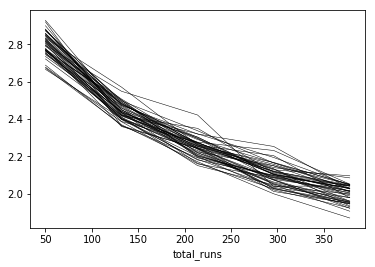

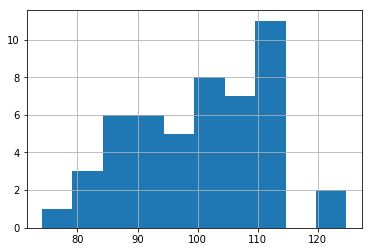

In [30]:
phi = pd.read_csv(os.path.join(m_d,"freyberg_ies.phi.actual.csv"),index_col=0)
phi.index = phi.total_runs
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,color='k')
plt.show()
phi.iloc[-1,6:].hist()

Plot forecast prior and posterior histograms with "truth" (red line)

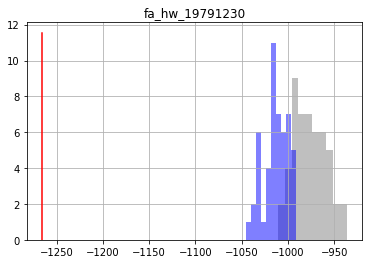

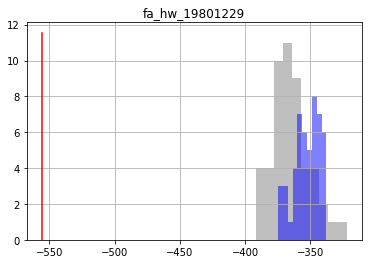

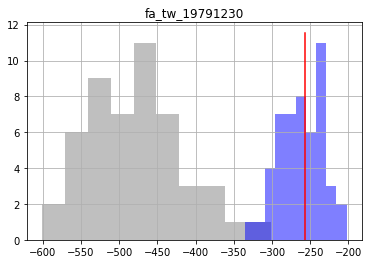

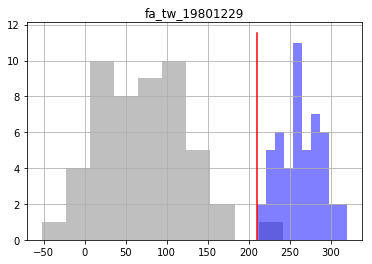

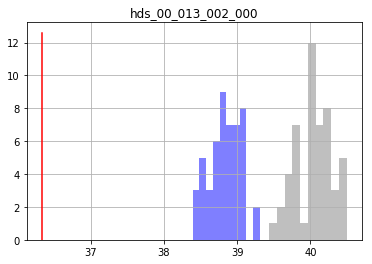

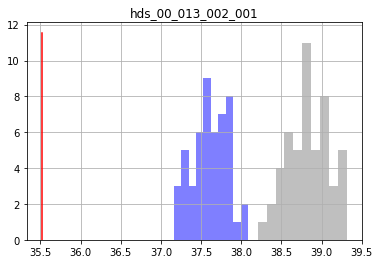

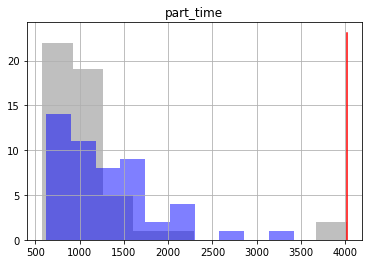

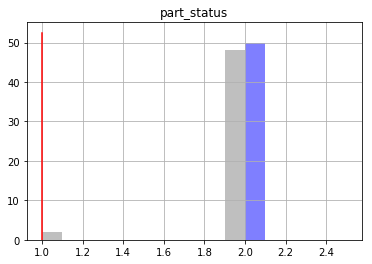

In [31]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(forecast)
    plt.show()

Plot parameter histograms by group

<Figure size 576x756 with 0 Axes>

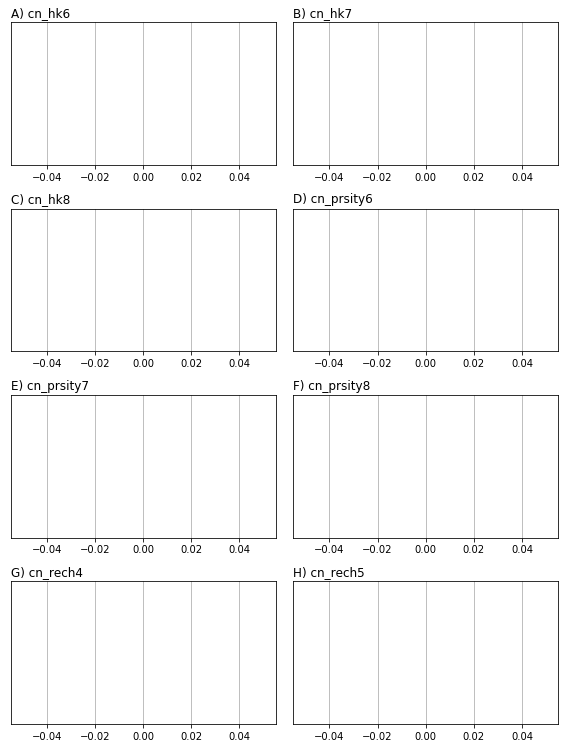

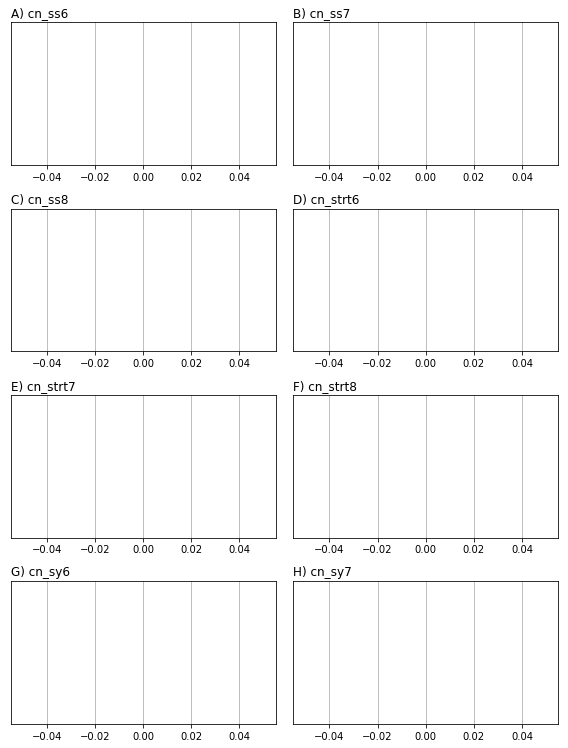

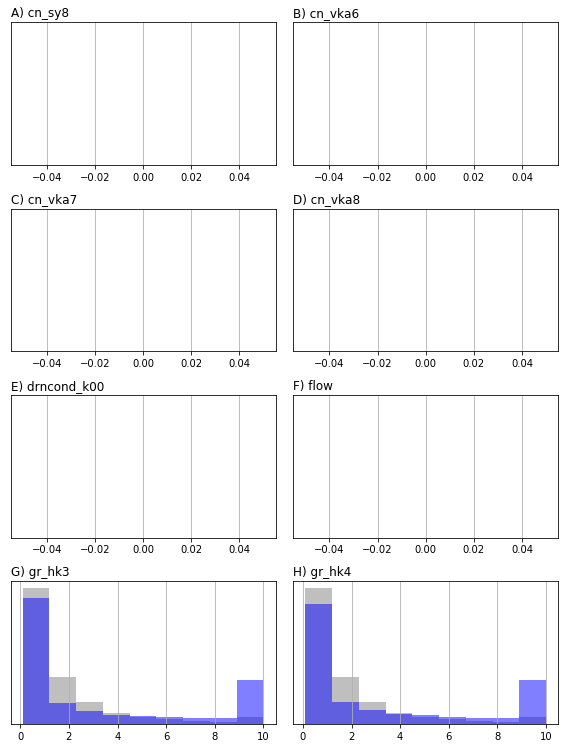

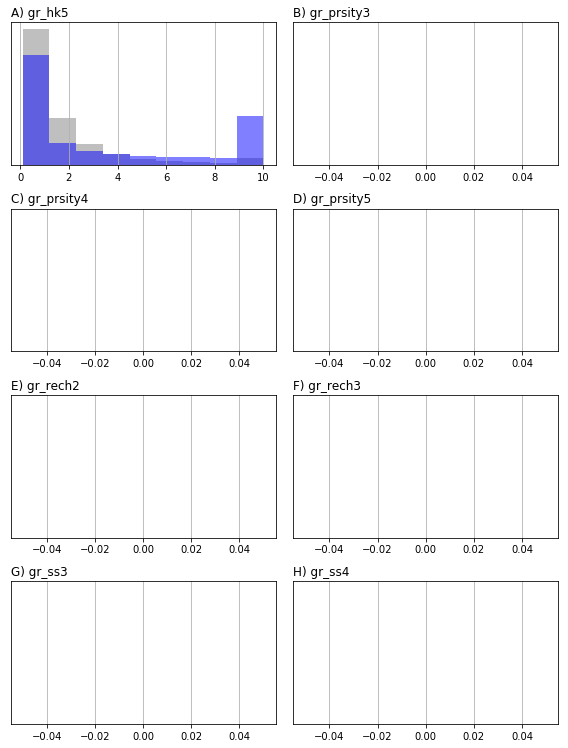

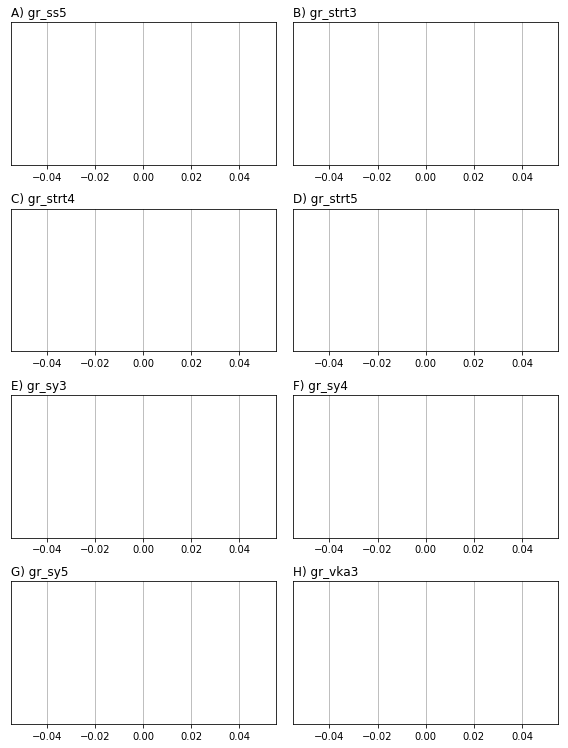

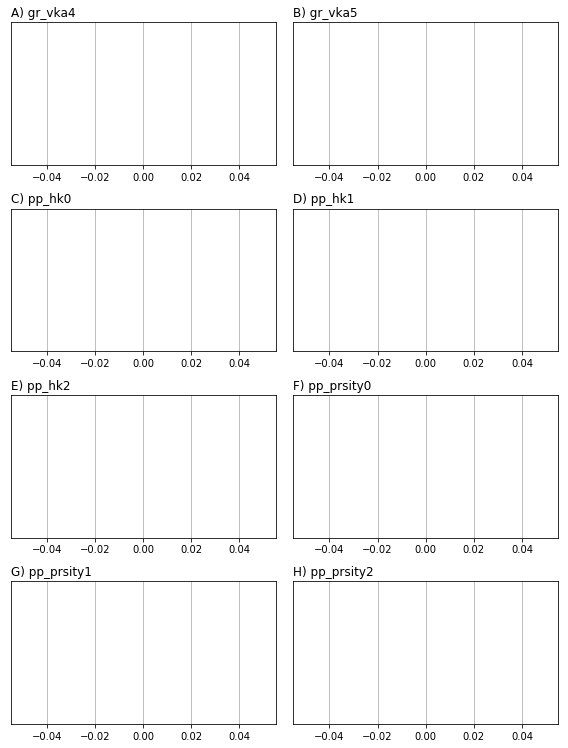

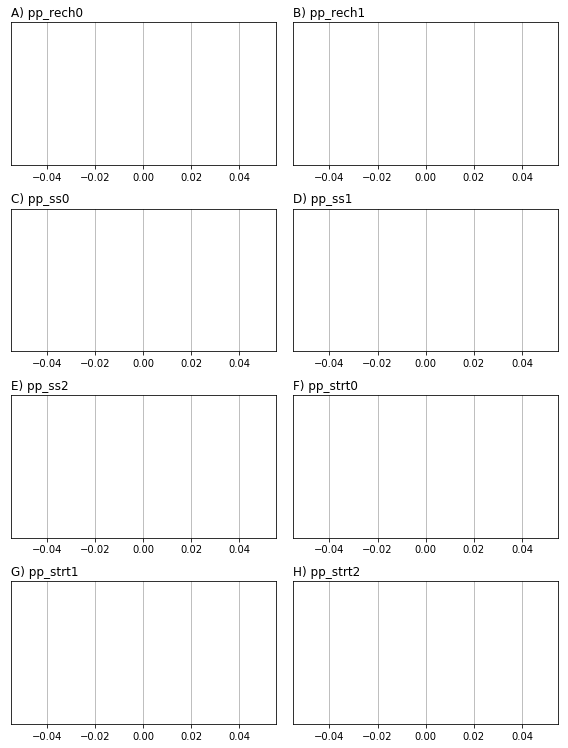

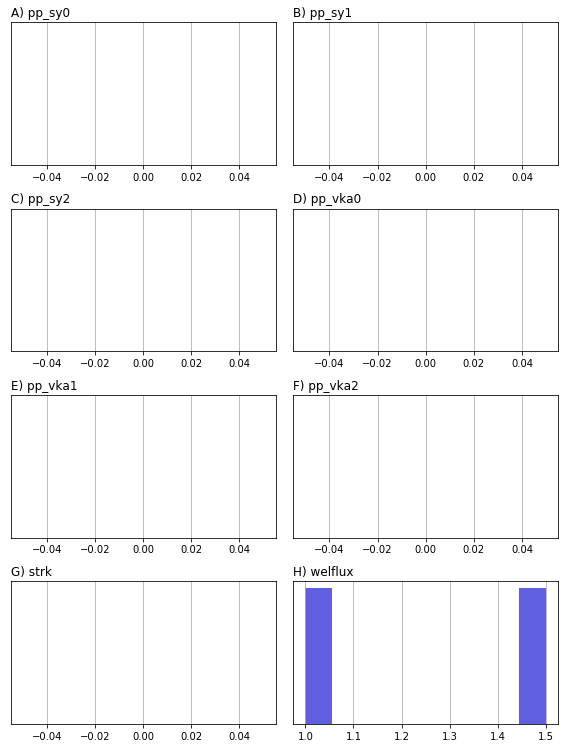

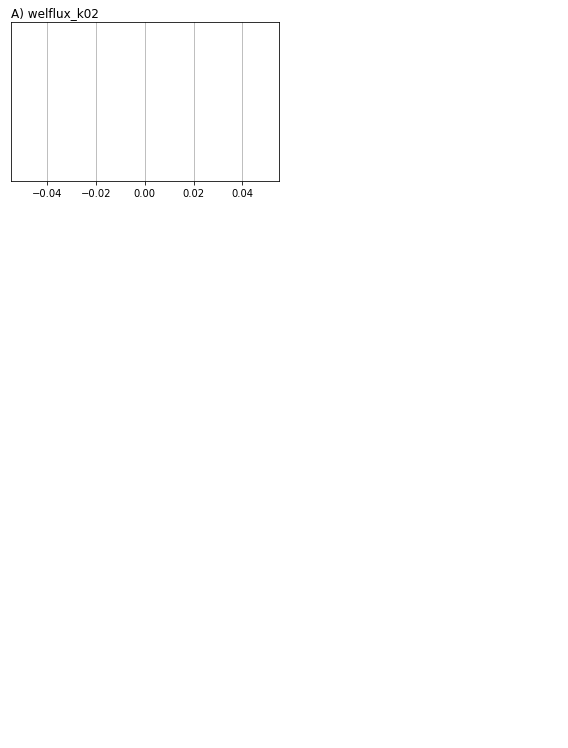

In [32]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)
par = pst.parameter_data
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)